In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression

import shap


d:\intern_project\intern_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
movies = pd.read_csv(
    "ml-1m/movies.dat",
    sep="::",
    engine="python",
    names=["movieId", "title", "genres"],
    encoding="latin-1"
)


In [4]:
ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    engine="python",
    names=["userId", "movieId", "rating", "timestamp"]
)

In [5]:
data = ratings.merge(movies, on="movieId")

In [6]:
movie_stats = data.groupby("movieId").agg(
    v=("rating", "count"),
    R=("rating", "mean")
).reset_index()

C = data["rating"].mean()
m = movie_stats["v"].quantile(0.90)

def imdb_weighted_rating(row):
    v, R = row["v"], row["R"]
    return (v / (v + m)) * R + (m / (v + m)) * C

movie_stats["weighted_rating"] = movie_stats.apply(imdb_weighted_rating, axis=1)

movie_scores = movie_stats.merge(movies, on="movieId")

# Global Top-N Movies (New + Existing)

In [7]:
def global_top_n_movies(top_n=10):
    return movie_scores.sort_values(
        "weighted_rating", ascending=False
    ).head(top_n)[["movieId","title", "genres", "weighted_rating"]]


# Genre-Based Global Top-N (NEW USER)

In [8]:
def global_genre_top_n(genre, top_n=10):
    genre_movies = movie_scores[
        movie_scores["genres"].str.contains(genre, case=False)
    ]

    return genre_movies.sort_values(
        "weighted_rating", ascending=False
    ).head(top_n)[["title", "genres", "weighted_rating"]]


In [9]:
user_movie_matrix = data.pivot_table(
    index="userId",
    columns="movieId",
    values="rating"
)

user_movie_filled = user_movie_matrix.fillna(0)


In [10]:
user_similarity = cosine_similarity(user_movie_filled)
user_similarity_df = pd.DataFrame(
    user_similarity,
    index=user_movie_filled.index,
    columns=user_movie_filled.index
)


In [11]:
def user_preferred_top_n(user_id, top_n=10):
    similar_users = (
        user_similarity_df[user_id]
        .sort_values(ascending=False)
        .iloc[1:6]
    )

    scores = np.zeros(user_movie_filled.shape[1])

    for sim_user, sim in similar_users.items():
        scores += sim * user_movie_filled.loc[sim_user].values

    scores = pd.Series(scores, index=user_movie_filled.columns)

    watched = user_movie_matrix.loc[user_id].dropna().index
    scores = scores.drop(watched, errors="ignore")

    return (
        scores.sort_values(ascending=False)
        .head(top_n)
        .reset_index()
        .merge(movies, on="movieId")
        [["movieId", "title", "genres"]]
    )


In [12]:
def user_genre_top_n(user_id, genre, top_n=10):
    user_recs = user_preferred_top_n(user_id, top_n=100)

    return user_recs[
        user_recs["genres"].str.contains(genre, case=False)
    ].head(top_n)


In [13]:
def run_experiment(user_id=None, genre=None, top_n=10):
    """
    Case 1: New user, no genre       -> Global Top N
    Case 2: New user, genre given    -> Global Genre Top N
    Case 3: Existing user, no genre  -> Global Top N + User Preferred Top N
    Case 4: Existing user, genre     -> Global Genre Top N + User Genre Top N
    """

    if user_id is None and genre is None:
        return {
            "global_top": global_top_n_movies(top_n)
        }

    if user_id is None and genre is not None:
        return {
            "global_genre_top": global_genre_top_n(genre, top_n)
        }

    if user_id is not None and genre is None:
        return {
            "global_top": global_top_n_movies(top_n),
            "user_preferred_top": user_preferred_top_n(user_id, top_n)
        }

    return {
        "global_genre_top": global_genre_top_n(genre, top_n),
        "user_genre_top": user_genre_top_n(user_id, genre, top_n)
    }


In [14]:
result = run_experiment(user_id=None, genre=None)

result["global_top"][["title", "genres", "weighted_rating"]]


,title,genres,weighted_rating
309,"Shawshank Redemption, The (1994)",Drama,4.314477
802,"Godfather, The (1972)",Action|Crime|Drama,4.291872
513,Schindler's List (1993),Drama|War,4.287045
253,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,4.282691
1108,Raiders of the Lost Ark (1981),Action|Adventure,4.276168
49,"Usual Suspects, The (1995)",Crime|Thriller,4.245473
2557,"Sixth Sense, The (1999)",Thriller,4.217579
2651,American Beauty (1999),Comedy|Drama,4.188275
579,"Silence of the Lambs, The (1991)",Drama|Thriller,4.181935
1848,Saving Private Ryan (1998),Action|Drama|War,4.174354


In [15]:
result = run_experiment(user_id=None, genre="Action")

result["global_genre_top"][["title", "genres", "weighted_rating"]]

,title,genres,weighted_rating
802,"Godfather, The (1972)",Action|Crime|Drama,4.291872
253,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,4.282691
1108,Raiders of the Lost Ark (1981),Action|Adventure,4.276168
1848,Saving Private Ryan (1998),Action|Drama|War,4.174354
2374,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.154466
1106,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,4.153448
1107,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance,4.130845
1131,"Godfather: Part II, The (1974)",Action|Crime|Drama,4.123787
106,Braveheart (1995),Action|Drama|War,4.084713
1839,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama,4.034439


In [16]:
result = run_experiment(user_id=1, genre=None)

result["global_top"][["title", "genres", "weighted_rating"]]


,title,genres,weighted_rating
309,"Shawshank Redemption, The (1994)",Drama,4.314477
802,"Godfather, The (1972)",Action|Crime|Drama,4.291872
513,Schindler's List (1993),Drama|War,4.287045
253,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,4.282691
1108,Raiders of the Lost Ark (1981),Action|Adventure,4.276168
49,"Usual Suspects, The (1995)",Crime|Thriller,4.245473
2557,"Sixth Sense, The (1999)",Thriller,4.217579
2651,American Beauty (1999),Comedy|Drama,4.188275
579,"Silence of the Lambs, The (1991)",Drama|Thriller,4.181935
1848,Saving Private Ryan (1998),Action|Drama|War,4.174354


In [17]:
result["user_preferred_top"][["title", "genres"]]

,title,genres
0,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance
1,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical
2,"Silence of the Lambs, The (1991)",Drama|Thriller
3,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance
4,Sleeping Beauty (1959),Animation|Children's|Musical
5,101 Dalmatians (1961),Animation|Children's
6,Babe (1995),Children's|Comedy|Drama
7,Jurassic Park (1993),Action|Adventure|Sci-Fi
8,Charlotte's Web (1973),Animation|Children's
9,Pinocchio (1940),Animation|Children's


In [23]:
result = run_experiment(user_id=1, genre="Drama")

result["global_genre_top"][["title", "genres", "weighted_rating"]]


,title,genres,weighted_rating
309,"Shawshank Redemption, The (1994)",Drama,4.314477
802,"Godfather, The (1972)",Action|Crime|Drama,4.291872
513,Schindler's List (1993),Drama|War,4.287045
2651,American Beauty (1999),Comedy|Drama,4.188275
579,"Silence of the Lambs, The (1991)",Drama|Thriller,4.181935
1848,Saving Private Ryan (1998),Action|Drama|War,4.174354
851,Casablanca (1942),Drama|Romance|War,4.159996
1106,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,4.153448
1104,One Flew Over the Cuckoo's Nest (1975),Drama,4.150235
1131,"Godfather: Part II, The (1974)",Action|Crime|Drama,4.123787


In [24]:
result["user_genre_top"][["title", "genres"]]

,title,genres
2,"Silence of the Lambs, The (1991)",Drama|Thriller
6,Babe (1995),Children's|Comedy|Drama
11,American Beauty (1999),Comedy|Drama
19,Jerry Maguire (1996),Drama|Romance
23,Braveheart (1995),Action|Drama|War
34,Say Anything... (1989),Comedy|Drama|Romance
37,Pulp Fiction (1994),Crime|Drama
39,Gladiator (2000),Action|Drama
40,Boiler Room (2000),Drama
41,"Godfather: Part II, The (1974)",Action|Crime|Drama


In [20]:
movie_stats.head()

,movieId,v,R,weighted_rating
0,1,2077,4.146846,3.999911
1,2,701,3.201141,3.395142
2,3,478,3.016736,3.357972
3,4,170,2.729412,3.420513
4,5,296,3.006757,3.415652


In [21]:
X = movie_stats[["v", "R"]]
y = movie_stats["weighted_rating"]

explain_model = LinearRegression()
explain_model.fit(X, y)

explainer = shap.Explainer(explain_model, X)


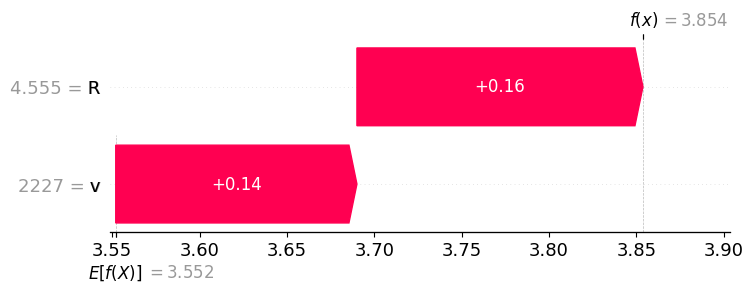

In [22]:
# Explain top global movie
top_movie = global_top_n_movies(1).iloc[0]
top_movie_id = top_movie["movieId"]

X_explain = movie_stats[movie_stats["movieId"] == top_movie_id][["v", "R"]]

shap_values = explainer(X_explain)

shap.plots.waterfall(shap_values[0])
